In [1]:
import importlib.resources
import os

from lang2vec import data as lang2vec_data
import lang2vec.lang2vec as l2v
import matplotlib
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import pandas as pd
import pycountry
import umap

Ellipsis

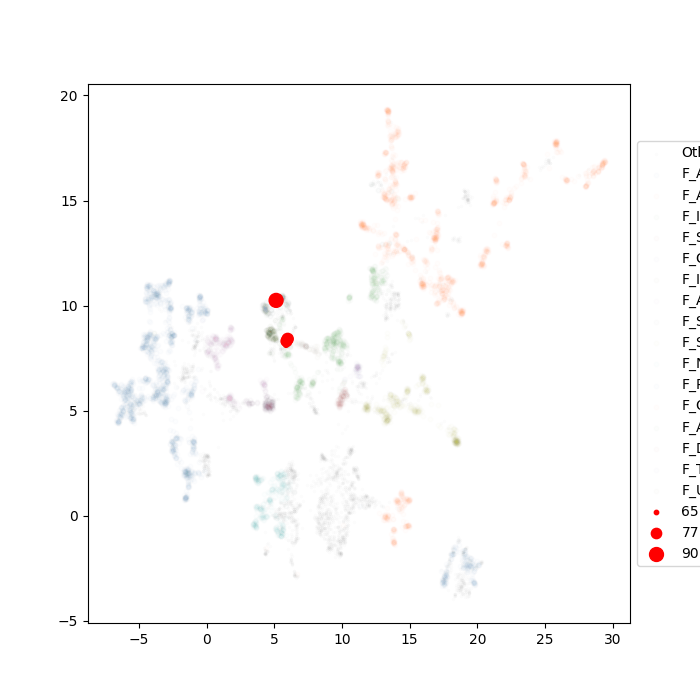

In [16]:
%matplotlib widget

def visualize(
    backend,
    features,
    color_families=False,
    legend_families=False,
    alpha=1,
    zoom=None,  # left right bottom up
    evaluation=None,
):
    if color_families == True:
        color_families = [
            'Atlantic-Congo',
            'Austronesian',
            'Indo-European',
            'Slavic',
            'Germanic',
            'Italic',
            'Afro-Asiatic',
            'Semitic',
            'Sino-Tibetan',
            'Nuclear_Trans_New_Guinea',
            'Pama-Nyungan',
            'Otomanguean',
            'Austroasiatic',
            'Dravidian',
            'Turkic',
            'Uralic',
        ]
    
    if color_families:
        color_families = ['F_' + family for family in color_families]
    
    if backend == 'matplotlib':
        
        plt.rcParams["figure.figsize"] = (7, 7)
        
        if features == 'uriel':
    
            if color_families:
                other = df[~df[color_families].any(axis=1)]
                plt.scatter(other.uriel_x, other.uriel_y, 3, c='gray', marker='o', label='Other' if legend_families else None, alpha=alpha)
                for family in color_families:
                    family_df = df[df[family] == 1]
                    plt.scatter(family_df.uriel_x, family_df.uriel_y, 10, marker='o', label=family if legend_families else None, alpha=alpha)
                    # TODO: fix colors
                    # TODO: select each language only once, e.g. Indo-European vs Slavic

            else:
                plt.scatter(df.uriel_x, df.uriel_y, 3, marker='o', c='gray', alpha=alpha)
                
            if zoom is not None:
                plt.xlim(zoom[0], zoom[1])
                plt.ylim(zoom[2], zoom[3])
                
            if evaluation is not None:
                subset_df = df.loc[evaluation.languages]
                plt.scatter(subset_df['uriel_x'], subset_df['uriel_y'], s=evaluation.sizes, c=evaluation.colors)
                
                if evaluation.legend:
                    for label, color, size in zip(evaluation.legend['labels'], evaluation.legend['colors'], evaluation.legend['sizes']):
                        plt.scatter(None, None, s=size, color=color, label=label)

        elif features == 'geo':
            
            if zoom is None:
                zoom = (-180, 180, -60, 75)

            m = Basemap(
                projection='merc',
                llcrnrlat=zoom[2],
                urcrnrlat=zoom[3],
                llcrnrlon=zoom[0],
                urcrnrlon=zoom[1],
                lat_ts=20,
                resolution='c'
            )
            m.drawcoastlines()
            m.fillcontinents(color='white', lake_color='white')
            m.drawparallels(np.arange(-90.,91.,30.), labels=[True,False,False,False])
            m.drawmeridians(np.arange(-180.,181.,60.), labels=[False,True,True,False])
            m.drawmapboundary(fill_color='white')

            
            if color_families:
                other = df[~df[color_families].any(axis=1)]
                m.scatter(*m(other.longitude, other.latitude), 3, c='gray', marker='o', zorder=3, label='Other' if legend_families else None, alpha=alpha)
                for family in color_families:
                    family_df = df[df[family] == 1]
                    m.scatter(*m(family_df.longitude, family_df.latitude), 10, marker='o', label=family if legend_families else None, zorder=3, alpha=alpha)
                    # TODO: fix colors
                    # TODO: select each language only once, e.g. Indo-European vs Slavic
            else:
                m.scatter(*m(df.longitude, df.latitude), 10, marker='o', color='gray', zorder=3, alpha=alpha)
                
            if evaluation is not None:
                subset_df = df.loc[evaluation.languages]
                plt.scatter(*m(subset_df['longitude'], subset_df['latitude']), s=evaluation.sizes, c=evaluation.colors, zorder=3)
                
                if evaluation.legend:
                    for label, color, size in zip(evaluation.legend['labels'], evaluation.legend['colors'], evaluation.legend['sizes']):
                        plt.scatter(None, None, s=size, color=color, label=label)                
            
        else:
            raise AttributeError('Attribute `features` muse be either `uriel` or `geo`.')
    
        plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
            
    elif backend == 'bokeh':
        ...

class Evaluation:
    
    def __init__(self, languages, sizes, colors, legend):
        self.languages = languages
        self.sizes = sizes
        self.colors = colors
        self.legend = legend
        
    def visualize(self, *args, **kwargs):
        visualize(*args, **kwargs, evaluation=self)
    
    @classmethod
    def compare_two_methods(cls, languages, score_diff, method_names):
        
        colors = ['g' if s > 0 else 'r' for s in score_diff]
        scores = [s if s > 0 else -s for s in score_diff]
        mx, mn = max(scores), min(scores)
        scores = [s - min(scores) for s in scores]  # normalization
        scores = [s / max(scores) for s in scores]  # normalization
        sizes = [s * 90 + 10 for s in scores]  # 20-100 scale
        
        method_a, method_b = method_names
        legend = {
            'labels': [
                f'{method_a} wins by {mx}',
                f'{method_a} wins by {(mx + mn) / 2}',
                f'{method_a} wins by {mn}',
                f'{method_b} wins by {mn}',
                f'{method_b} wins by {(mx + mn) / 2}',
                f'{method_b} wins by {mx}',
            ],
            'colors': ['g', 'g', 'g', 'r', 'r', 'r'],
            'sizes': [100, 55, 10, 10, 55, 100],
        }
        
        return Evaluation(
            languages=languages,
            sizes=sizes,
            colors=colors,
            legend=legend,
        )
        
    @classmethod
    def show_winner(cls, languages, winners):
        methods = list(set(winners))
        cm = matplotlib.cm.get_cmap('tab20').colors
        cm = cm[::2] + cm[1::2]
        
        legend = {
            'labels': methods,
            'colors': cm[:len(methods)],
            'sizes': [50 for _ in range(len(methods))],
        }
        
        return Evaluation(
            languages=languages,
            sizes=50,
            colors=[cm[methods.index(w)] for w in winners],
            legend=legend,
        )
        
    @classmethod
    def show_languages(cls, languages, color='r'):
        return Evaluation(
            languages=languages,
            sizes=50,
            colors=color,
        )
        
    @classmethod
    def show_performance(cls, languages, scores, color='r'):  # scores should be scaled by user and with max being better
        mn, mx = min(scores), max(scores)
        scores = [s - min(scores) for s in scores]  # normalization
        scores = [s / max(scores) for s in scores]  # normalization
        sizes = [s * 90 + 10 for s in scores]  # 20-100 scale
        
        legend = {
            'labels': [
                f'{mn}',
                f'{(mx + mn) / 2}',
                f'{mx}',
            ],
            'colors': [color, color, color],
            'sizes': [10, 55, 100],
        }
        
        # TODO: legend
        return Evaluation(
            languages=languages,
            sizes=sizes,
            colors=color,
            legend=legend,
        )
        
Evaluation.show_performance(['slk', 'ces', 'hbs', 'rus', 'eng'], [75, 80, 79, 65, 90]).\
visualize('matplotlib', 'uriel', alpha=0.01, color_families=True, legend_families=True)#, zoom=[0,10,-5,5])
...

In [ ]:
import umap.plot
import bokeh

hover_data = pd.DataFrame({
    'family': df['family_str'],
    'iso': df.index,
    'name': df['name'],
})
hover_data.index = range(7970)

p = umap.plot.interactive(
    umap_object,
    hover_data=hover_data,
    interactive_text_search=True,
    point_size=4,
)
bokeh.plotting.output_notebook() 
bokeh.plotting.show(p)

In [ ]:
import numpy as np
from types import FunctionType
from utils import language_iso

@language_iso
def rahimi_ner():
    languages = [line.split()[0] for line in open('./papers/rahimi_ner.txt')]
    scores = np.vstack([
        [float(v) for v in line.split()[2:]]
        for line
        in open('./papers/rahimi_ner.txt')
    ])
    return languages, scores

@language_iso
def heinzerling_ner():
    languages = [line.split()[0] for line in open('./papers/heinzerling_ner.txt')]
    scores = np.vstack([
        [float(v) for v in line.split()[1:]]
        for line
        in open('./papers/heinzerling_ner.txt')
    ])
    return languages, scores

@language_iso
def heinzerling_pos():
    languages = [line.split()[0] for line in open('./papers/heinzerling_pos.txt')]
    scores = np.vstack([
        [float(v) for v in line.split()[1:]]
        for line
        in open('./papers/heinzerling_pos.txt')
    ])
    return languages, scores


In [ ]:
languages = [line.split()[0] for line in open('./papers/heinzerling_ner.txt')]
languages = [LETTER_CODES.get(l, l) for l in languages]
languages

In [26]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'uriel_codes' is not defined

In [106]:
from main import LinguisticDatabase

ldb = LinguisticDatabase().load()
ldb.fields.keys()

loading URIEl
loading geo
loading family
loading names


dict_keys(['uriel', 'uriel_umap', 'geo', 'family'])

In [79]:
from main import Visualization

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


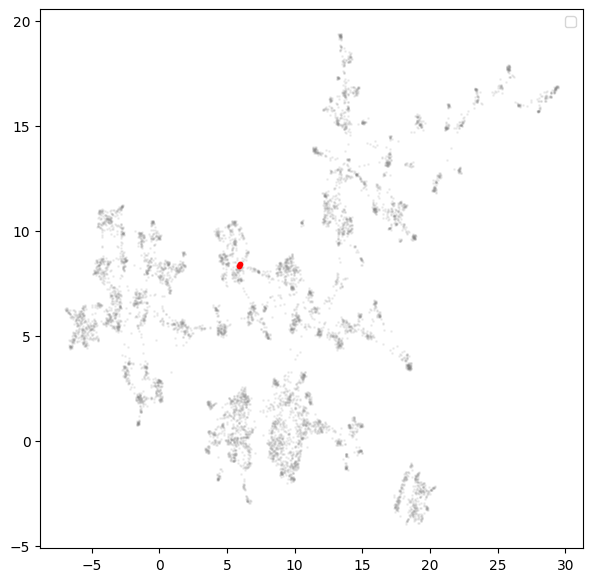

In [114]:
%matplotlib inline

vis = Visualization(feature='uriel', size=(7,7), zoom=None, backend='matplotlib', ldb=ldb).load()
vis.show_all_languages(c='grey', s=1, alpha=0.1)
vis.visualize_points(['slk', 'ces'], s=10, c='r')